# **Processes Head data set**
All id to single 1d array stored in csv file with corresponding metadata


In [8]:
import pandas as pd
import numpy as np
import os

def process_head_tracking_data(input_csv_path, participant_id, video_name,
                                fps=60, frame_interval=5, cols=16, rows=9):
    """
    Process head tracking data and convert to tile indices

    Parameters:
    -----------
    input_csv_path : str
        Path to the input CSV file
    participant_id : int or str
        ID of the participant to filter, or 'ALL' for mode across all participants
    video_name : int
        Video identifier to filter
    fps : int
        Frames per second (default: 60)
    frame_interval : int
        Take every nth frame (default: 5)
    cols : int
        Number of columns in tile grid (default: 16)
    rows : int
        Number of rows in tile grid (default: 9)

    Returns:
    --------
    tile_indices_array : numpy array
        1D array of tile indices
    target_timestamps : numpy array
        Corresponding timestamps for each tile index
    mode_str : str
        'mono' or 'stereo'
    """

    # Read the CSV file
    print(f"Reading CSV file: {input_csv_path}")
    df = pd.read_csv(input_csv_path)

    # Function to convert (u, v) coordinates to tile index
    def uv_to_tile_index(u, v):
        """Convert normalized coordinates (u, v) to tile index"""
        col = int(u * cols)
        row = int(v * rows)

        # Clamp to valid range
        col = min(col, cols - 1)
        row = min(row, rows - 1)

        # Calculate tile index (row-major order)
        tile_index = row * cols + col
        return tile_index

    if participant_id == 'ALL':
        # Process all participants and find mode per frame
        print("\nProcessing ALL participants (mode calculation):")

        # Filter for video only
        filtered_df = df[df['video'] == video_name]

        if len(filtered_df) == 0:
            raise ValueError(f"No data found for video {video_name}")

        # Check stereo mode (use first occurrence)
        stereo_mode = filtered_df['stereo'].iloc[0]
        mode_str = "stereo" if stereo_mode else "mono"

        # Get all unique participants
        all_participants = filtered_df['id'].unique()
        print(f"  Video: {video_name}")
        print(f"  Mode: {mode_str}")
        print(f"  Number of participants: {len(all_participants)}")
        print(f"  Participant IDs: {sorted(all_participants)}")

        # Parameters
        time_interval = frame_interval / fps

        # Get max time across all participants
        max_time = filtered_df['t'].max()
        target_timestamps = np.arange(0, max_time + time_interval, time_interval)

        print(f"  Video duration: {max_time:.2f} seconds")
        print(f"  Target timestamps: {len(target_timestamps)} (every {frame_interval} frames)")

        # For each target timestamp, collect tile indices from all participants
        mode_tile_indices = []

        for target_t in target_timestamps:
            participant_tiles = []

            # Get tile index for each participant at this timestamp
            for pid in all_participants:
                participant_data = filtered_df[filtered_df['id'] == pid]

                if len(participant_data) > 0:
                    # Find closest timestamp for this participant
                    idx = (participant_data['t'] - target_t).abs().idxmin()
                    u = participant_data.loc[idx, 'u']
                    v = participant_data.loc[idx, 'v']
                    tile_idx = uv_to_tile_index(u, v)
                    participant_tiles.append(tile_idx)

            # Calculate mode (most common tile index)
            if len(participant_tiles) > 0:
                # Use bincount to find mode efficiently
                counts = np.bincount(participant_tiles)
                mode_tile = np.argmax(counts)
                mode_tile_indices.append(mode_tile)
            else:
                # Fallback: use center tile if no data
                mode_tile_indices.append((rows // 2) * cols + (cols // 2))

        tile_indices_array = np.array(mode_tile_indices)

    else:
        # Original single participant processing
        filtered_df = df[(df['id'] == participant_id) & (df['video'] == video_name)]

        if len(filtered_df) == 0:
            raise ValueError(f"No data found for participant {participant_id} and video {video_name}")

        # Check stereo mode
        stereo_mode = filtered_df['stereo'].iloc[0]
        mode_str = "stereo" if stereo_mode else "mono"

        # Sort by timestamp
        filtered_df = filtered_df.sort_values('t').reset_index(drop=True)

        print(f"\nProcessing:")
        print(f"  Participant ID: {participant_id}")
        print(f"  Video: {video_name}")
        print(f"  Mode: {mode_str}")
        print(f"  Samples in filtered data: {len(filtered_df)}")

        # Parameters
        time_interval = frame_interval / fps

        # Get video duration
        max_time = filtered_df['t'].max()
        target_timestamps = np.arange(0, max_time + time_interval, time_interval)

        print(f"  Video duration: {max_time:.2f} seconds")
        print(f"  Target timestamps: {len(target_timestamps)} (every {frame_interval} frames)")

        # Find closest timestamp in data for each target timestamp
        tile_indices = []

        for target_t in target_timestamps:
            idx = (filtered_df['t'] - target_t).abs().idxmin()
            u = filtered_df.loc[idx, 'u']
            v = filtered_df.loc[idx, 'v']
            tile_idx = uv_to_tile_index(u, v)
            tile_indices.append(tile_idx)

        tile_indices_array = np.array(tile_indices)

    print(f"\nGenerated {len(tile_indices_array)} tile indices")
    print(f"Tile index range: {tile_indices_array.min()} to {tile_indices_array.max()}")

    return tile_indices_array, target_timestamps, mode_str


def tile_index_to_coords(tile_index, cols=16):
    """
    Convert tile index to (row, col) coordinates

    Parameters:
    -----------
    tile_index : int or array
        Tile index or array of indices
    cols : int
        Number of columns in grid

    Returns:
    --------
    row, col : int or array
        Row and column coordinates
    """
    row = tile_index // cols
    col = tile_index % cols
    return row, col


def tile_distance_loss_euclidean(actual_indices, predicted_indices, cols=16):
    """
    Calculate loss based on Euclidean distance between actual and predicted tiles

    Parameters:
    -----------
    actual_indices : array
        Array of actual tile indices
    predicted_indices : array
        Array of predicted tile indices
    cols : int
        Number of columns in grid

    Returns:
    --------
    loss : float
        Mean Euclidean distance between actual and predicted tiles
    distances : array
        Individual distances for each prediction
    """
    # Convert indices to coordinates
    actual_rows, actual_cols = tile_index_to_coords(actual_indices, cols)
    pred_rows, pred_cols = tile_index_to_coords(predicted_indices, cols)

    # Calculate Euclidean distance between coordinates
    distances = np.sqrt((actual_rows - pred_rows)**2 + (actual_cols - pred_cols)**2)

    # Mean distance as loss
    loss = np.mean(distances)

    return loss, distances


def save_tile_indices_to_csv(tile_indices, timestamps, participant_id, video_name,
                              mode_str, fps, frame_interval, output_dir='.'):
    """
    Save tile indices to CSV file with proper naming (includes metadata)
    """

    # Format video name with leading zeros
    video_str = f"{video_name:04d}"

    # Handle participant_id as string or int
    pid_str = str(participant_id)

    # Create filename
    filename = f"id{pid_str}_head_video_{video_str}_{mode_str}_{fps}fps_{frame_interval}th_frames.csv"
    output_path = os.path.join(output_dir, filename)

    # Create DataFrame
    output_df = pd.DataFrame({
        'frame_index': np.arange(0, len(tile_indices) * frame_interval, frame_interval),
        'timestamp': timestamps,
        'tile_index': tile_indices
    })

    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"\nOutput with metadata saved to: {output_path}")
    print(f"Output shape: {output_df.shape}")
    print(f"\nFirst 10 rows of output:")
    print(output_df.head(10))

    return output_path


def save_tile_indices_cnn_format(tile_indices, participant_id, video_name,
                                  mode_str, fps, frame_interval, output_dir='.'):
    """
    Save tile indices as a single line CSV for CNN input (no metadata, no headers)
    Just the 1D array of tile indices
    """

    # Format video name with leading zeros
    video_str = f"{video_name:04d}"

    # Handle participant_id as string or int
    pid_str = str(participant_id)

    # Create filename with _cnn suffix
    filename = f"id{pid_str}_head_video_{video_str}_{mode_str}_{fps}fps_{frame_interval}th_frames_cnn.csv"
    output_path = os.path.join(output_dir, filename)

    # Save as single line without header or index - JUST THE TILE INDICES
    np.savetxt(output_path, tile_indices.reshape(1, -1), delimiter=',', fmt='%d')

    print(f"\nCNN format (1D array only) saved to: {output_path}")
    print(f"Array length: {len(tile_indices)}")
    print(f"First 20 tile indices: {tile_indices[:20]}")
    print(f"Last 20 tile indices: {tile_indices[-20:]}")

    return output_path

In [2]:
# ==================== CELL 1: UPLOAD AND PROCESS ====================

# Configuration
PARTICIPANT_ID = 'ALL'  # Use 'ALL' for mode across all participants, or specific ID like 11
VIDEO_NAME = 1  # Video 001
FPS = 60
FRAME_INTERVAL = 5
TILE_COLS = 16
TILE_ROWS = 9

# Upload file
print("Upload your CSV file:")
from google.colab import files
uploaded = files.upload()
INPUT_CSV_PATH = list(uploaded.keys())[0]

# Process the data
tile_indices, timestamps, mode_str = process_head_tracking_data(
    input_csv_path=INPUT_CSV_PATH,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    fps=FPS,
    frame_interval=FRAME_INTERVAL,
    cols=TILE_COLS,
    rows=TILE_ROWS
)

print("\n" + "="*60)
print("PROCESSING COMPLETE!")
print("="*60)

Upload your CSV file:


Saving head_video_0001.csv to head_video_0001.csv
Reading CSV file: head_video_0001.csv

Processing ALL participants (mode calculation):
  Video: 1
  Mode: mono
  Number of participants: 69
  Participant IDs: [np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(11), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(22), np.int64(23), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(40), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(50), np.int64(52), np.int64(53), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(70), np.int64(71), np.int64(73), np.int64(75), np.int64(76), np.int64(77), np.int64(78

In [3]:
# ==================== CELL 2: SAVE FILES ====================

# Save to CSV with metadata (frame_index, timestamp, tile_index)
output_path = save_tile_indices_to_csv(
    tile_indices=tile_indices,
    timestamps=timestamps,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    mode_str=mode_str,
    fps=FPS,
    frame_interval=FRAME_INTERVAL
)

# Save to CSV for CNN input (single line, just tile indices)
output_path_cnn = save_tile_indices_cnn_format(
    tile_indices=tile_indices,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    mode_str=mode_str,
    fps=FPS,
    frame_interval=FRAME_INTERVAL
)

print("\n" + "="*60)
print("FILES SAVED!")
print("="*60)


Output with metadata saved to: ./idALL_head_video_0001_mono_60fps_5th_frames.csv
Output shape: (362, 3)

First 10 rows of output:
   frame_index  timestamp  tile_index
0            0   0.000000          73
1            5   0.083333          73
2           10   0.166667          73
3           15   0.250000          73
4           20   0.333333          73
5           25   0.416667          73
6           30   0.500000          73
7           35   0.583333          73
8           40   0.666667          74
9           45   0.750000          74

CNN format (1D array only) saved to: ./idALL_head_video_0001_mono_60fps_5th_frames_cnn.csv
Array length: 362
First 20 tile indices: [73 73 73 73 73 73 73 73 74 74 74 74 74 73 75 75 75 76 76 76]
Last 20 tile indices: [75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75]

FILES SAVED!


In [4]:
# ==================== CELL 3: DOWNLOAD METADATA CSV ====================
from google.colab import files

print("Downloading metadata CSV file...")
print(f"Filename: {os.path.basename(output_path)}")
files.download(output_path)
print("✓ Downloaded!")

Filename: idALL_head_video_0001_mono_60fps_5th_frames.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded!


In [5]:
# ==================== CELL 4: DOWNLOAD CNN FORMAT CSV ====================
from google.colab import files

print("Downloading CNN format CSV file (1D array only)...")
print(f"Filename: {os.path.basename(output_path_cnn)}")
files.download(output_path_cnn)
print("✓ Downloaded!")

Filename: idALL_head_video_0001_mono_60fps_5th_frames_cnn.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded!


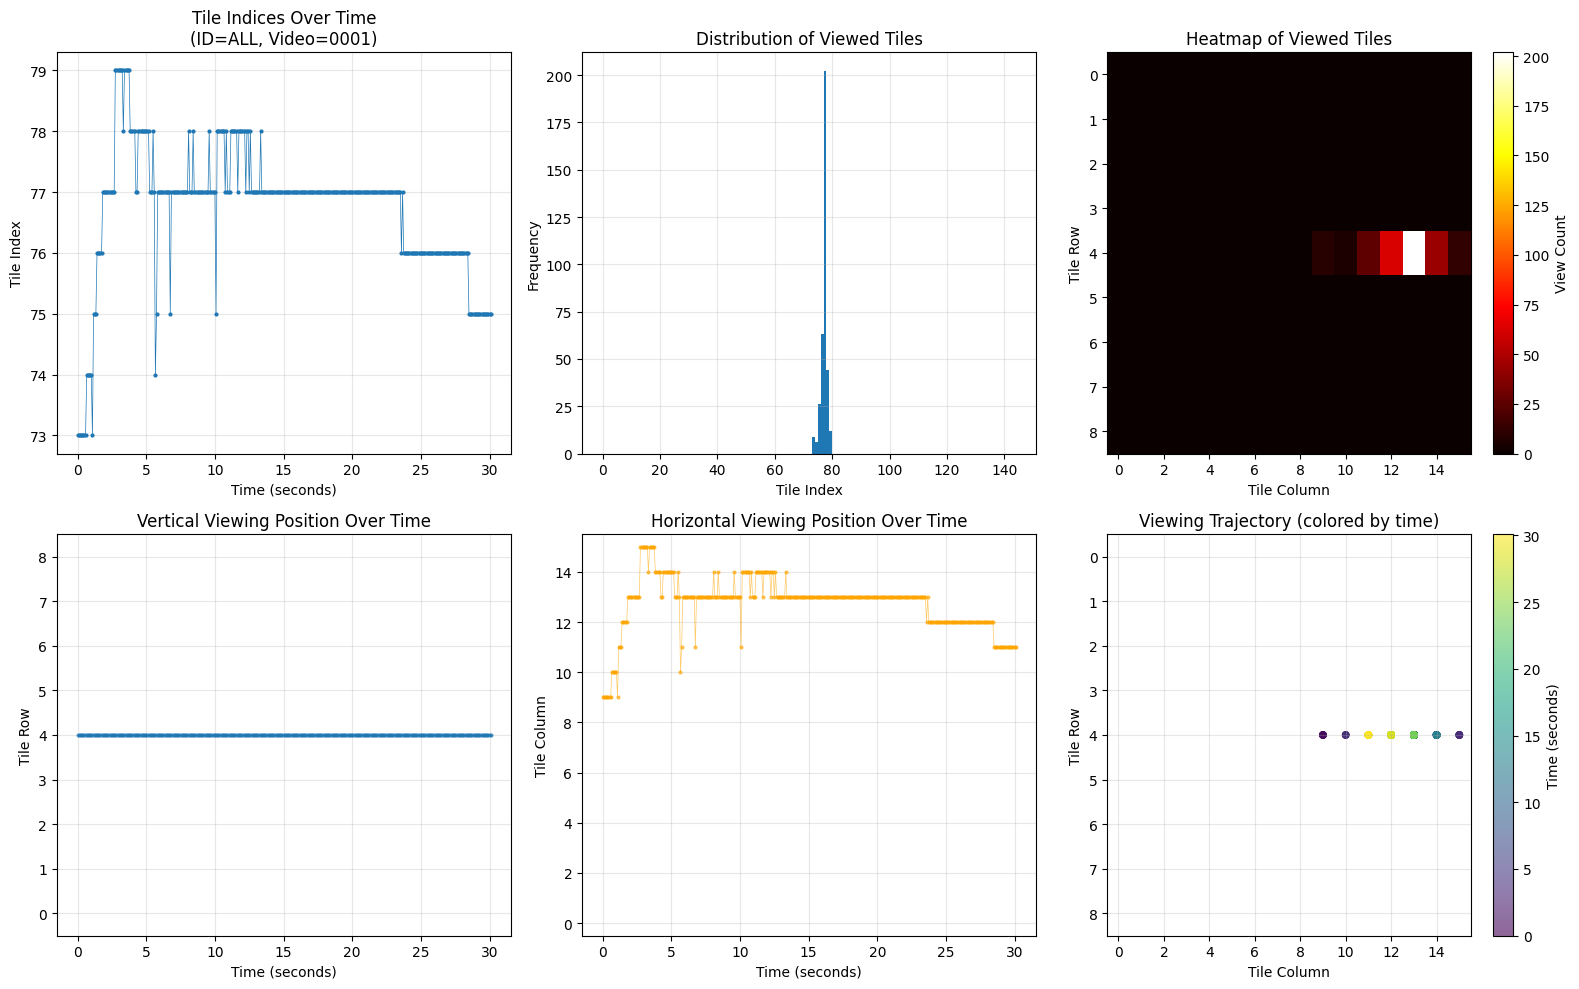


Visualization complete for ID=ALL, Video=1


In [6]:
# ==================== CELL 5: VISUALIZE RESULTS ====================
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Plot 1: Tile indices over time
plt.subplot(2, 3, 1)
plt.plot(timestamps, tile_indices, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Index')
title_str = f'Tile Indices Over Time\n(ID={PARTICIPANT_ID}, Video={VIDEO_NAME:04d})'
plt.title(title_str)
plt.grid(True, alpha=0.3)

# Plot 2: Distribution histogram
plt.subplot(2, 3, 2)
plt.hist(tile_indices, bins=TILE_COLS * TILE_ROWS, range=(0, TILE_COLS * TILE_ROWS))
plt.xlabel('Tile Index')
plt.ylabel('Frequency')
plt.title('Distribution of Viewed Tiles')
plt.grid(True, alpha=0.3)

# Plot 3: Heatmap
plt.subplot(2, 3, 3)
tile_counts = np.bincount(tile_indices, minlength=TILE_COLS * TILE_ROWS)
heatmap = tile_counts.reshape(TILE_ROWS, TILE_COLS)
plt.imshow(heatmap, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='View Count')
plt.xlabel('Tile Column')
plt.ylabel('Tile Row')
plt.title('Heatmap of Viewed Tiles')
plt.xticks(range(0, TILE_COLS, 2))
plt.yticks(range(TILE_ROWS))

# Plot 4: Row distribution over time
plt.subplot(2, 3, 4)
rows, cols = tile_index_to_coords(tile_indices, TILE_COLS)
plt.plot(timestamps, rows, marker='o', markersize=2, linestyle='-', linewidth=0.5, alpha=0.6)
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Row')
plt.title('Vertical Viewing Position Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, TILE_ROWS - 0.5)

# Plot 5: Column distribution over time
plt.subplot(2, 3, 5)
plt.plot(timestamps, cols, marker='o', markersize=2, linestyle='-', linewidth=0.5, alpha=0.6, color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Column')
plt.title('Horizontal Viewing Position Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, TILE_COLS - 0.5)

# Plot 6: 2D trajectory
plt.subplot(2, 3, 6)
scatter = plt.scatter(cols, rows, c=timestamps, cmap='viridis', s=20, alpha=0.6)
plt.colorbar(scatter, label='Time (seconds)')
plt.xlabel('Tile Column')
plt.ylabel('Tile Row')
plt.title('Viewing Trajectory (colored by time)')
plt.xlim(-0.5, TILE_COLS - 0.5)
plt.ylim(TILE_ROWS - 0.5, -0.5)  # Invert y-axis to match screen coordinates
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete for ID={PARTICIPANT_ID}, Video={VIDEO_NAME}")

In [7]:
# ==================== CELL 6: LOSS FUNCTION DEMO ====================

print("="*60)
print("EUCLIDEAN DISTANCE LOSS FUNCTION DEMO")
print("="*60)

# Simulate some predictions for demonstration
np.random.seed(42)
num_samples = min(50, len(tile_indices))
sample_indices = np.random.choice(len(tile_indices), num_samples, replace=False)
actual = tile_indices[sample_indices]

# Simulate predictions with some random offset
pred_offset = np.random.randint(-3, 4, size=num_samples)
predicted = np.clip(actual + pred_offset, 0, TILE_COLS * TILE_ROWS - 1)

# Calculate Euclidean distance loss
euclidean_loss, euclidean_distances = tile_distance_loss_euclidean(actual, predicted, TILE_COLS)

# Calculate naive index difference (for comparison)
naive_loss = np.mean(np.abs(actual - predicted))

print(f"\nSample size: {num_samples} frames")
print(f"\nNaive Index Difference: {naive_loss:.4f}")
print(f"  (NOT spatially aware - just abs difference)")
print(f"\nEuclidean Distance Loss: {euclidean_loss:.4f} tiles")
print(f"  (Spatially aware - uses tile coordinates)")

print(f"\nExample predictions (first 5):")
print("-" * 70)
for i in range(min(5, num_samples)):
    actual_row, actual_col = tile_index_to_coords(actual[i], TILE_COLS)
    pred_row, pred_col = tile_index_to_coords(predicted[i], TILE_COLS)
    print(f"  Sample {i}:")
    print(f"    Actual:    tile {actual[i]:3d} at position ({actual_row}, {actual_col})")
    print(f"    Predicted: tile {predicted[i]:3d} at position ({pred_row}, {pred_col})")
    print(f"    Distance:  {euclidean_distances[i]:.3f} tiles")
    print()

print("="*60)
print("USE THIS LOSS FUNCTION IN YOUR CNN TRAINING:")
print("="*60)
print("""
import numpy as np

def tile_distance_loss_euclidean(actual_indices, predicted_indices, cols=16):
    actual_rows = actual_indices // cols
    actual_cols = actual_indices % cols
    pred_rows = predicted_indices // cols
    pred_cols = predicted_indices % cols

    distances = np.sqrt((actual_rows - pred_rows)**2 + (actual_cols - pred_cols)**2)
    return np.mean(distances)
""")

EUCLIDEAN DISTANCE LOSS FUNCTION DEMO

Sample size: 50 frames

Naive Index Difference: 1.6200
  (NOT spatially aware - just abs difference)

Euclidean Distance Loss: 3.7475 tiles
  (Spatially aware - uses tile coordinates)

Example predictions (first 5):
----------------------------------------------------------------------
  Sample 0:
    Actual:    tile  77 at position (4, 13)
    Predicted: tile  77 at position (4, 13)
    Distance:  0.000 tiles

  Sample 1:
    Actual:    tile  79 at position (4, 15)
    Predicted: tile  80 at position (5, 0)
    Distance:  15.033 tiles

  Sample 2:
    Actual:    tile  75 at position (4, 11)
    Predicted: tile  75 at position (4, 11)
    Distance:  0.000 tiles

  Sample 3:
    Actual:    tile  76 at position (4, 12)
    Predicted: tile  73 at position (4, 9)
    Distance:  3.000 tiles

  Sample 4:
    Actual:    tile  78 at position (4, 14)
    Predicted: tile  80 at position (5, 0)
    Distance:  14.036 tiles

USE THIS LOSS FUNCTION IN YOUR CNN 